In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional
from collections import defaultdict
from tqdm.notebook import tqdm

In [2]:
import torch
import torch.nn.functional as F

from mamba_ssm.modules.ssd_minimal import (
    ssd_minimal_discrete,
    ssd_minimal_discrete_alt,
    ssd_minimal_no_chunk_linear,
)
from mamba_ssm.ops.triton.ssd_combined import mamba_chunk_scan_combined
from triton.testing import do_bench


In [12]:
def get_xdtABC(
    seqlen=4096,
    d_model=2560,
    expand=2,
    headdim=32,
    ngroups=1,
    dstate=8,
    dtype=torch.bfloat16,
    device="cuda",
    requires_grad: bool = False,
    batch_size: int = 1,
    nheads: Optional[int] = None,
):
    nheads = nheads or (d_model * expand) // headdim
    x = torch.randn(
        batch_size,
        seqlen,
        nheads,
        headdim,
        dtype=dtype,
        device=device,
        requires_grad=requires_grad,
    )
    dt = F.softplus(
        torch.randn(
            batch_size,
            seqlen,
            nheads,
            dtype=dtype,
            device=device,
        )
        - 4
    )
    A = -torch.exp(
        torch.rand(
            nheads,
            dtype=dtype,
            device=device,
        )
    )
    if requires_grad:
        # Set dt and A as requires_grad, and not the tensors they're built from, so that they
        # are leaf tensors which accumulate gradients.
        dt.requires_grad_()
        A.requires_grad_()
    B = torch.randn(
        batch_size,
        seqlen,
        ngroups,
        dstate,
        dtype=dtype,
        device=device,
        requires_grad=requires_grad,
    )
    C = torch.randn(
        batch_size,
        seqlen,
        ngroups,
        dstate,
        dtype=dtype,
        device=device,
        requires_grad=requires_grad,
    )
    return (
        x.contiguous(),
        dt.contiguous(),
        A.contiguous(),
        B.contiguous(),
        C.contiguous(),
    )


In [13]:
def bench(seqlen: int, batch_size: int, chunk_size: int, compile: bool, res_dict: dict, warmup: int = 100, rep: int = 500):
    x, dt, A, B, C = get_xdtABC(seqlen=seqlen, batch_size=batch_size)
    kernel_args = (x, dt, A, B, C, chunk_size)
    
    def kernel_args_wrapper(x, dt, A, B, C, chunk_size):
        return (x * dt.unsqueeze(-1), A * dt, B, C, chunk_size)

    impl_dict = {
        "discrete": lambda *kernel_args: ssd_minimal_discrete(
            *kernel_args_wrapper(*kernel_args)
        ),
        "discrete_alt": lambda *kernel_args: ssd_minimal_discrete_alt(
            *kernel_args_wrapper(*kernel_args)
        ),
        "no_chunk_linear": lambda *kernel_args: ssd_minimal_no_chunk_linear(
            *kernel_args_wrapper(*kernel_args)[:-1]
        ),
        "mamba_ssm": mamba_chunk_scan_combined
    }
    
    res_dict["seqlen"].append(seqlen)
    res_dict["batch_size"].append(batch_size)
    res_dict["chunk_size"].append(chunk_size)
    res_dict["compile"].append(compile)
    for name, impl in tqdm(impl_dict.items(), desc="impl"):
        # Don't compile the mamba impl
        try:
            if name != "mamba_ssm" and compile:
                impl = torch.compile(impl, fullgraph=True, mode="max-autotune")
                name += "_compile"
        
            bench_fn = lambda: impl(*kernel_args)
            if name != "mamba_ssm" and compile:
                # Compile
                bench_fn()
        
            mean_time_ms = do_bench(bench_fn, warmup=warmup, rep=rep)
        except Exception as e:
            print(f"Found exception: {e}")
            mean_time_ms = None
        res_dict[name + "_ms"].append(mean_time_ms)

In [14]:
res_dict = defaultdict(list)
total_tok = 2**14
for batch_size in tqdm((1, 2, 4, 8), desc="batch_size"):
    for chunk_size in tqdm((8, 16, 32, 64, 128, 256), desc="chunk_size"):
        bench(seqlen=total_tok // batch_size, batch_size=batch_size, chunk_size=chunk_size, compile=True, res_dict=res_dict)

batch_size:   0%|          | 0/4 [00:00<?, ?it/s]

chunk_size:   0%|          | 0/6 [00:00<?, ?it/s]

impl:   0%|          | 0/4 [00:00<?, ?it/s]

AUTOTUNE bmm(2048x8x8, 2048x8x5120)
  triton_bmm_706 0.2403 ms 100.0%
  triton_bmm_704 0.2410 ms 99.7%
  triton_bmm_709 0.2469 ms 97.3%
  triton_bmm_705 0.2473 ms 97.2%
  triton_bmm_708 0.2474 ms 97.1%
  triton_bmm_703 0.2516 ms 95.5%
  triton_bmm_700 0.2520 ms 95.4%
  triton_bmm_702 0.2520 ms 95.4%
  triton_bmm_707 0.2521 ms 95.3%
  triton_bmm_701 0.2916 ms 82.4%
SingleProcess AUTOTUNE benchmarking takes 6.7367 seconds and 0.0000 seconds precompiling
AUTOTUNE bmm(2048x8x8, 2048x8x8)
  triton_bmm_666 0.0087 ms 100.0%
  triton_bmm_668 0.0087 ms 100.0%
  triton_bmm_667 0.0093 ms 92.8%
  triton_bmm_664 0.0095 ms 91.6%
  triton_bmm_665 0.0095 ms 91.4%
  bmm 0.0098 ms 88.9%
SingleProcess AUTOTUNE benchmarking takes 2.6883 seconds and 0.0000 seconds precompiling
E0129 16:50:58.889383 23408834306048 torch/_inductor/select_algorithm.py:1455] [3/0] Runtime error during autotuning: 
E0129 16:50:58.889383 23408834306048 torch/_inductor/select_algorithm.py:1455] [3/0] Triton Error [CUDA]: invalid 

impl:   0%|          | 0/4 [00:00<?, ?it/s]

AUTOTUNE bmm(1024x16x8, 1024x8x5120)
  triton_bmm_789 0.1674 ms 100.0%
  triton_bmm_791 0.1681 ms 99.6%
  triton_bmm_785 0.1714 ms 97.7%
  triton_bmm_787 0.1716 ms 97.6%
  triton_bmm_788 0.1717 ms 97.5%
  triton_bmm_792 0.1724 ms 97.1%
  triton_bmm_794 0.1727 ms 97.0%
  triton_bmm_793 0.1729 ms 96.8%
  triton_bmm_790 0.1732 ms 96.7%
  triton_bmm_784 0.1764 ms 94.9%
SingleProcess AUTOTUNE benchmarking takes 1.5806 seconds and 0.0008 seconds precompiling
W0129 16:51:28.652009 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/1] ps0 is not in var_ranges, defaulting to unknown range.
W0129 16:51:28.660027 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/1] ps0 is not in var_ranges, defaulting to unknown range.
AUTOTUNE bmm(1024x16x8, 1024x8x16)
  triton_bmm_752 0.0084 ms 100.0%
  triton_bmm_753 0.0084 ms 100.0%
  bmm 0.0090 ms 93.6%
  triton_bmm_750 0.0091 ms 92.1%
  triton_bmm_751 0.0092 ms 91.8%
  triton_bmm_749 0.0092 ms 91.3%
SingleProcess AUTOTUNE benchm

impl:   0%|          | 0/4 [00:00<?, ?it/s]

W0129 16:52:00.911599 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/2] ps0 is not in var_ranges, defaulting to unknown range.
W0129 16:52:00.915860 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/2] ps0 is not in var_ranges, defaulting to unknown range.
W0129 16:52:09.527906 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [4/2] ps0 is not in var_ranges, defaulting to unknown range.
W0129 16:52:09.531490 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [4/2] ps0 is not in var_ranges, defaulting to unknown range.


impl:   0%|          | 0/4 [00:00<?, ?it/s]

impl:   0%|          | 0/4 [00:00<?, ?it/s]

W0129 16:52:23.857650 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/3] ps0 is not in var_ranges, defaulting to unknown range.
W0129 16:52:23.861232 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/3] ps0 is not in var_ranges, defaulting to unknown range.
W0129 16:52:32.598940 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [4/3] ps0 is not in var_ranges, defaulting to unknown range.
W0129 16:52:32.602226 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [4/3] ps0 is not in var_ranges, defaulting to unknown range.


impl:   0%|          | 0/4 [00:00<?, ?it/s]

chunk_size:   0%|          | 0/6 [00:00<?, ?it/s]

impl:   0%|          | 0/4 [00:00<?, ?it/s]

AUTOTUNE bmm(2048x8x8, 2048x8x5120)
  triton_bmm_1082 0.2321 ms 100.0%
  triton_bmm_1084 0.2325 ms 99.8%
  triton_bmm_1085 0.3119 ms 74.4%
  triton_bmm_1080 0.3120 ms 74.4%
  triton_bmm_1078 0.3120 ms 74.4%
  triton_bmm_1081 0.3120 ms 74.4%
  triton_bmm_1083 0.3127 ms 74.2%
  triton_bmm_1087 0.3127 ms 74.2%
  triton_bmm_1086 0.3132 ms 74.1%
  triton_bmm_1077 0.3139 ms 73.9%
SingleProcess AUTOTUNE benchmarking takes 1.6443 seconds and 0.0000 seconds precompiling
W0129 16:52:56.729218 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/4] ps0 is not in var_ranges, defaulting to unknown range.
W0129 16:52:56.742793 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/4] ps1 is not in var_ranges, defaulting to unknown range.
W0129 16:52:56.754271 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/4] ps2 is not in var_ranges, defaulting to unknown range.
W0129 16:52:56.765324 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/4] ps3 is no

impl:   0%|          | 0/4 [00:00<?, ?it/s]

impl:   0%|          | 0/4 [00:00<?, ?it/s]

W0129 16:53:52.759927 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/5] ps0 is not in var_ranges, defaulting to unknown range.
W0129 16:53:52.773546 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/5] ps1 is not in var_ranges, defaulting to unknown range.
W0129 16:53:52.784804 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/5] ps2 is not in var_ranges, defaulting to unknown range.
W0129 16:53:52.795400 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/5] ps3 is not in var_ranges, defaulting to unknown range.
W0129 16:53:52.806188 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/5] ps0 is not in var_ranges, defaulting to unknown range.
W0129 16:53:52.816805 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/5] ps1 is not in var_ranges, defaulting to unknown range.
W0129 16:53:52.827222 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/5] ps2 is not in var_ranges, defaulting to 

impl:   0%|          | 0/4 [00:00<?, ?it/s]

impl:   0%|          | 0/4 [00:00<?, ?it/s]

W0129 16:54:37.646691 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/6] ps0 is not in var_ranges, defaulting to unknown range.
W0129 16:54:37.659466 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/6] ps1 is not in var_ranges, defaulting to unknown range.
W0129 16:54:37.671063 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/6] ps2 is not in var_ranges, defaulting to unknown range.
W0129 16:54:37.681681 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/6] ps3 is not in var_ranges, defaulting to unknown range.
W0129 16:54:37.692217 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/6] ps0 is not in var_ranges, defaulting to unknown range.
W0129 16:54:37.702352 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/6] ps1 is not in var_ranges, defaulting to unknown range.
W0129 16:54:37.712539 23408834306048 torch/fx/experimental/symbolic_shapes.py:4449] [3/6] ps2 is not in var_ranges, defaulting to 

impl:   0%|          | 0/4 [00:00<?, ?it/s]

chunk_size:   0%|          | 0/6 [00:00<?, ?it/s]

impl:   0%|          | 0/4 [00:00<?, ?it/s]

impl:   0%|          | 0/4 [00:00<?, ?it/s]

impl:   0%|          | 0/4 [00:00<?, ?it/s]

impl:   0%|          | 0/4 [00:00<?, ?it/s]

impl:   0%|          | 0/4 [00:00<?, ?it/s]

impl:   0%|          | 0/4 [00:00<?, ?it/s]

chunk_size:   0%|          | 0/6 [00:00<?, ?it/s]

impl:   0%|          | 0/4 [00:00<?, ?it/s]

impl:   0%|          | 0/4 [00:00<?, ?it/s]

impl:   0%|          | 0/4 [00:00<?, ?it/s]

impl:   0%|          | 0/4 [00:00<?, ?it/s]

impl:   0%|          | 0/4 [00:00<?, ?it/s]

impl:   0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
res_df = pd.DataFrame.from_dict(res_dict)
res_df

,seqlen,batch_size,chunk_size,compile,discrete_compile_ms,discrete_alt_compile_ms,no_chunk_linear_compile_ms,mamba_ssm_ms
0,16384,1,8,True,8.110383,3.369359,5.650108,14.000030
1,16384,1,16,True,4.087116,2.406846,5.651421,4.774336
2,16384,1,32,True,2.694717,2.343206,5.651807,2.572319
3,16384,1,64,True,2.729108,2.624227,5.651995,2.081390
4,16384,1,128,True,3.948998,3.881296,5.650294,2.078429
5,16384,1,256,True,6.022168,6.037282,5.651585,2.505099
6,8192,2,8,True,7.411367,3.962066,6.843882,13.522479
7,8192,2,16,True,3.913193,2.919790,6.728544,4.493548
8,8192,2,32,True,3.242838,2.900428,6.729926,2.430119
9,8192,2,64,True,3.512277,3.255232,6.729879,2.019421


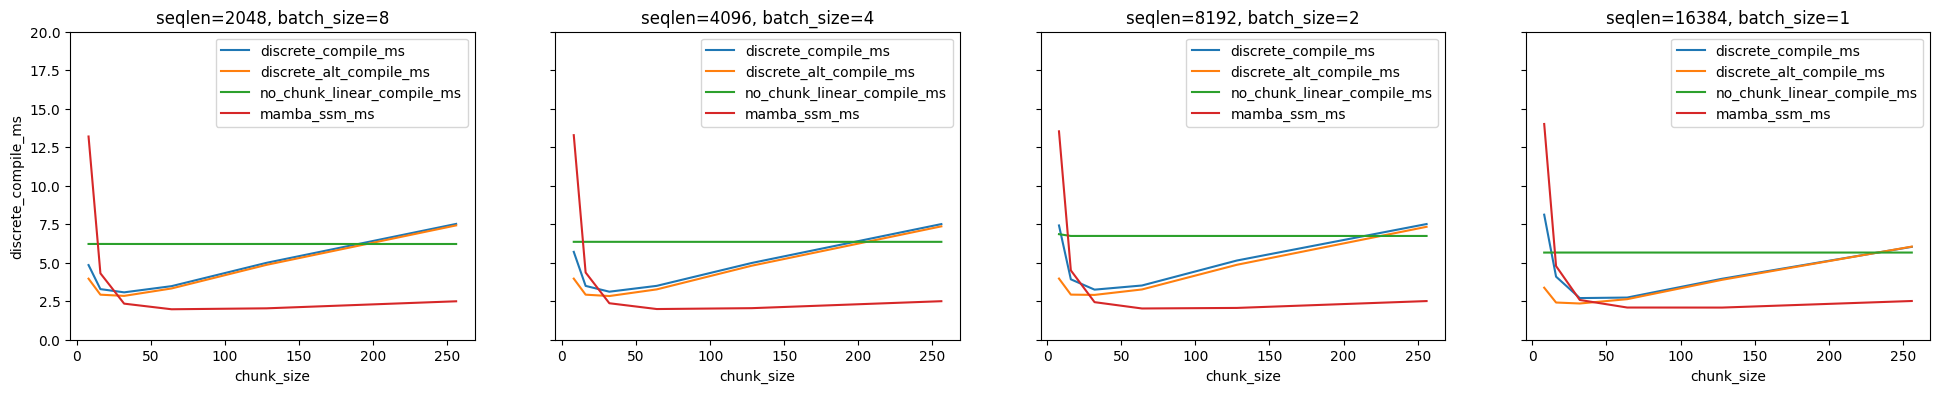

In [27]:
seqlens = list(sorted(res_df.seqlen.unique()))

fig, axs = plt.subplots(sharey=True, sharex=True, ncols=len(seqlens), figsize=(6*len(seqlens), 4))
for ax, seqlen in zip(axs, seqlens): 
    for name in res_df.columns:
        if name.endswith("_ms"):
            plot = sns.lineplot(data=res_df[res_df.seqlen==seqlen], x="chunk_size", y=name, ax=ax, label=name)
            # plot.set(xscale="log")
            # plot.set(yscale="log")
            ax.set_title(f"{seqlen=}, batch_size={total_tok // seqlen}")
            ax.set_ylim([0, 20])

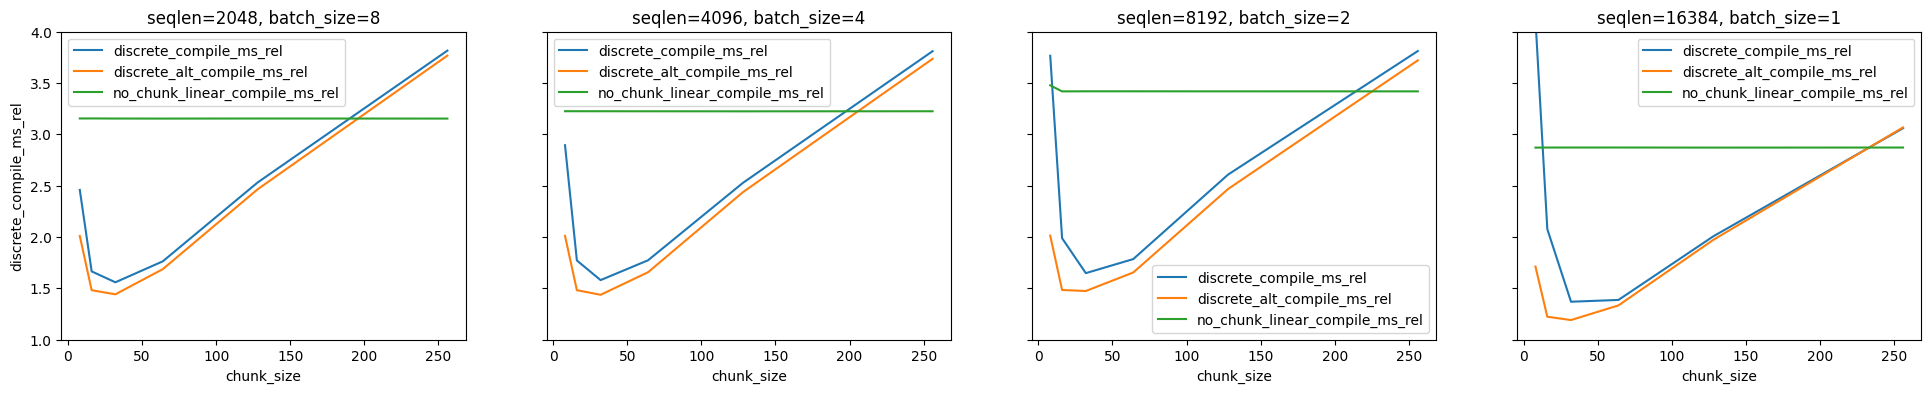

In [28]:
# Relative perf:
for name in res_df.columns:
        if name.endswith("_ms") and "mamba_ssm" not in name:
            res_df[name + "_rel"] = res_df[name] / res_df["mamba_ssm_ms"].min()

seqlens = list(sorted(res_df.seqlen.unique()))
fig, axs = plt.subplots(sharey=True, sharex=True, ncols=len(seqlens), figsize=(6*len(seqlens), 4))
for ax, seqlen in zip(axs, seqlens): 
    for name in res_df.columns:
        if name.endswith("_rel"):
            plot = sns.lineplot(data=res_df[res_df.seqlen==seqlen], x="chunk_size", y=name, ax=ax, label=name)
            # plot.set(xscale="log")
            # plot.set(yscale="log")
            ax.set_title(f"{seqlen=}, batch_size={total_tok // seqlen}")
            ax.set_ylim([1, 4])